For the dataset I chose Airbnb listings for Broward County from 25 Dec 2024.
Here is the link for listings.csv: https://insideairbnb.com/get-the-data/

In [6]:
#Install tidyverse package
install.packages(c("tidyverse", "xgboost"))

Installing packages into 'C:/Users/alexn/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'tidyverse' successfully unpacked and MD5 sums checked
package 'xgboost' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\alexn\AppData\Local\Temp\RtmpqG63Uo\downloaded_packages


In [7]:
# Load libraries
library(tidyverse)
library(ggplot2)
library(dplyr)
library(caret)
library(xgboost)

Warning message:
"package 'tidyverse' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'xgboost' was built under R version 4.4.3"

Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [8]:
# Loading dataset
airbnb = read.csv("listings.csv", stringsAsFactors = FALSE)

# Viewing first few rows
head(airbnb)

# Checking structure of data
str(airbnb)

# Checking for missing values
colSums(is.na(airbnb))


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
,<dbl>,<chr>,<int>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>
1,57818,50% OFF Monthly 32+days! Snowbird! Walk to beach!,275948,Von Inc,NA,Hollywood,26.01859,-80.12430,Entire home/apt,250,31,60,2024-03-08,0.41,2,305,1,
2,69824,2 bd/2ba Oceanfront Condo,351303,Tracy,NA,Hallandale Beach,25.97641,-80.12052,Entire home/apt,140,30,4,2023-06-03,0.09,2,291,0,
3,83449,2 miles from the beach 2/1 sleeps 5 #204,454736,"Jon, Mary Pop Apartments",NA,Dania Beach,26.03392,-80.14201,Entire home/apt,130,7,33,2024-12-14,0.21,16,127,2,
4,129099,MIAMI - AMAZING APARTMENT OCEANVIEW,637272,Bianca,NA,Hollywood,25.99414,-80.11814,Entire home/apt,328,15,28,2024-03-14,0.17,5,365,1,
5,191160,Tropical Beach Paradise Awaits You,924482,Dan,NA,Deerfield Beach,26.30707,-80.07793,Entire home/apt,119,2,25,2019-11-08,0.16,1,118,0,
6,216046,Dual Masters! - Adult Media/Game Rm - 1GB Internet,964836,Gary,NA,Hollywood,26.00770,-80.19722,Entire home/apt,274,2,114,2024-10-14,0.72,1,268,8,


'data.frame':	17167 obs. of  18 variables:
 $ id                            : num  57818 69824 83449 129099 191160 ...
 $ name                          : chr  "50% OFF Monthly 32+days! Snowbird!  Walk to beach!" "2 bd/2ba Oceanfront Condo" "2 miles from the beach 2/1 sleeps 5 #204" "MIAMI - AMAZING APARTMENT OCEANVIEW" ...
 $ host_id                       : int  275948 351303 454736 637272 924482 964836 637272 454736 1304156 1585064 ...
 $ host_name                     : chr  "Von Inc" "Tracy" "Jon,  Mary Pop Apartments" "Bianca" ...
 $ neighbourhood_group           : logi  NA NA NA NA NA NA ...
 $ neighbourhood                 : chr  "Hollywood" "Hallandale Beach" "Dania Beach" "Hollywood" ...
 $ latitude                      : num  26 26 26 26 26.3 ...
 $ longitude                     : num  -80.1 -80.1 -80.1 -80.1 -80.1 ...
 $ room_type                     : chr  "Entire home/apt" "Entire home/apt" "Entire home/apt" "Entire home/apt" ...
 $ price                         : int  250 1

id                           name 
                             0                              0 
                       host_id                      host_name 
                             0                              0 
           neighbourhood_group                  neighbourhood 
                         17167                              0 
                      latitude                      longitude 
                             0                              0 
                     room_type                          price 
                             0                           1184 
                minimum_nights              number_of_reviews 
                             0                              0 
                   last_review              reviews_per_month 
                             0                           3227 
calculated_host_listings_count               availability_365 
                             0                              0 
         number_of_reviews_ltm                        license 
                             0                              0

In [11]:
# Convert price column to remove "$" and convert to numeric
airbnb$price = as.numeric(gsub("\\$", "", airbnb$price))

# Convert last_review to Date format
airbnb$last_review = as.Date(airbnb$last_review)

# Replace missing values in reviews_per_month with 0
airbnb$reviews_per_month[is.na(airbnb$reviews_per_month)] = 0

# Remove rows where price is missing or zero
airbnb = airbnb %>% filter(!is.na(price) & price > 0)


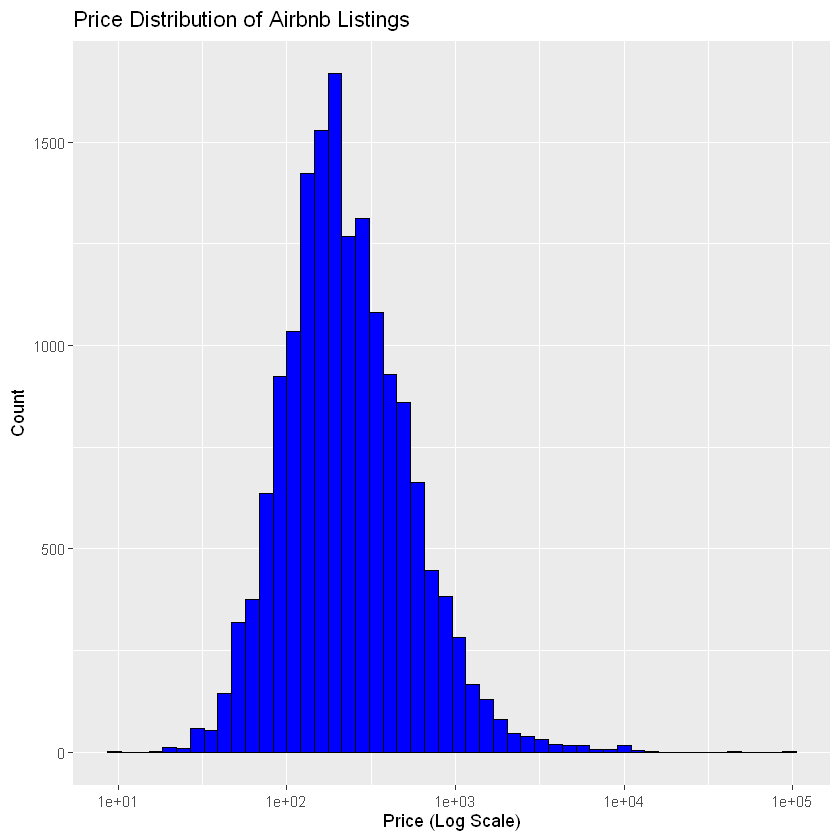

In [12]:
#Looking at price distribution
ggplot(airbnb, aes(x = price)) +
  geom_histogram(bins = 50, fill = "blue", color = "black") +
  scale_x_log10() + # Log transform to handle skewed data
  ggtitle("Price Distribution of Airbnb Listings") +
  xlab("Price (Log Scale)") + ylab("Count")


I used log transformation to normalize the data. Otherwise, few high-price listings and mostly low-price listings distribution would be disproportional; and therefore, not normal.

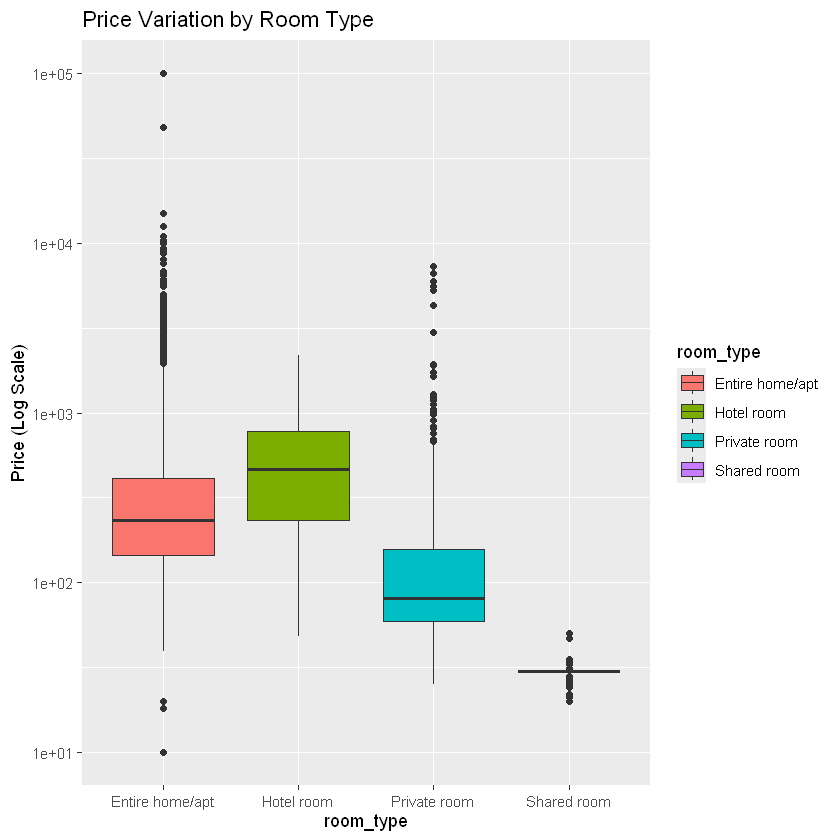

In [13]:
#Looking at price by room type
ggplot(airbnb, aes(x = room_type, y = price, fill = room_type)) +
  geom_boxplot() +
  scale_y_log10() +
  ggtitle("Price Variation by Room Type") +
  ylab("Price (Log Scale)")


From this boxplot, we can see that the entire property price is higher than private rooms, and shared rooms have the lowest prices.

`geom_smooth()` using formula = 'y ~ x'


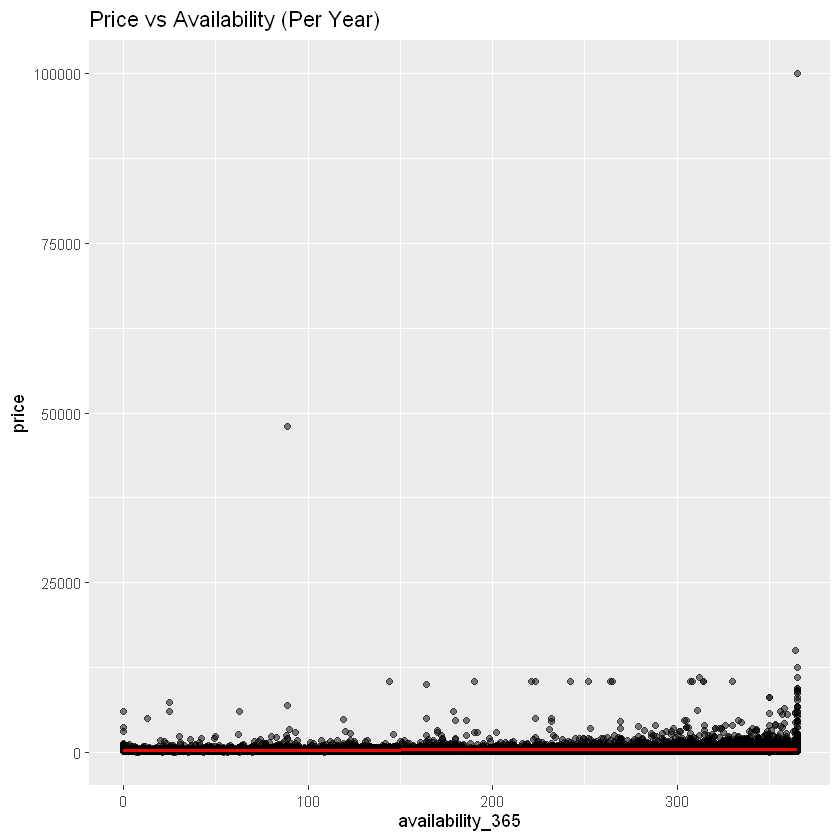

In [20]:
#availability vs price
ggplot(airbnb, aes(x = availability_365, y = price)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", color = "red") +
  ggtitle("Price vs Availability (Per Year)")


It seems that the red linear trend line is slightly going upward, so that means that higher-priced listings are available more often. It is also nearly flat, so we also can conclude that price and availability are not strongly correlated.

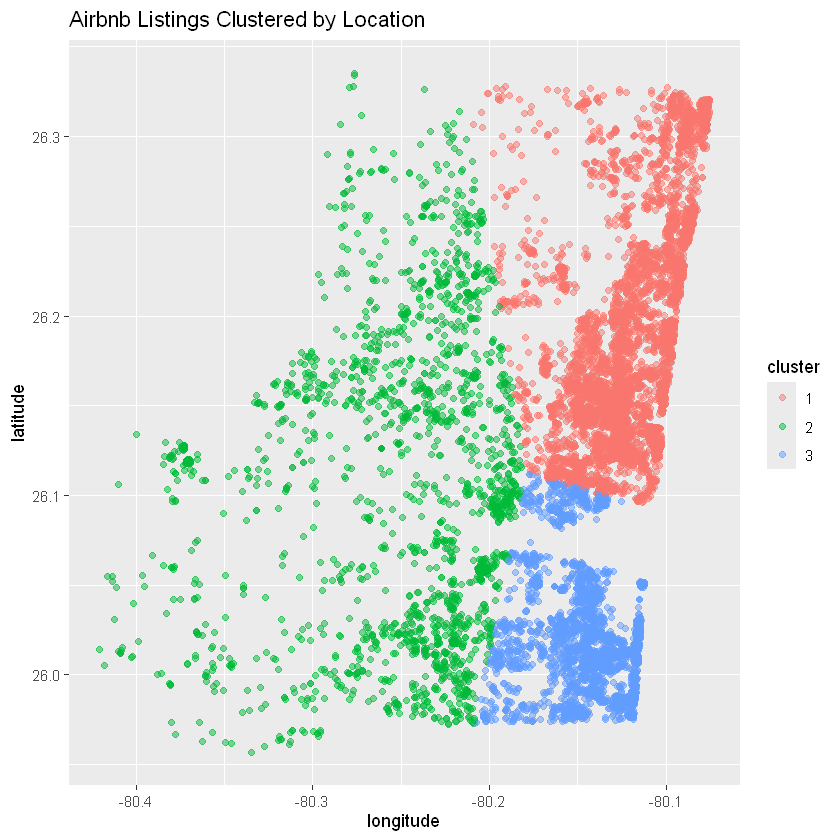

In [16]:
# Selecting only numeric data for clustering
location_data = airbnb %>% select(latitude, longitude)

# Standardize the data
location_scaled = scale(location_data)

# Perform K-Means with optimal clusters (assuming 3 clusters)
set.seed(123)
kmeans_result = kmeans(location_scaled, centers = 3, nstart = 25)

# Add cluster labels to the dataset
airbnb$cluster = as.factor(kmeans_result$cluster)

# Visualize Clusters
ggplot(airbnb, aes(x = longitude, y = latitude, color = cluster)) +
  geom_point(alpha = 0.5) +
  ggtitle("Airbnb Listings Clustered by Location")



In my opinion, assuming 3 clusters worked out pretty well, as listings were split into beachfront and non-beachfront, and beachfront was split into 2 clusters where high-demand tourists regions occur like Fort Lauderdale, Hollywood, Pompano.

In [17]:
# Prepare data for regression
model_data = airbnb %>%
  select(price, room_type, minimum_nights, number_of_reviews, availability_365, calculated_host_listings_count)

# Convert categorical variables to factors
model_data$room_type = as.factor(model_data$room_type)

# Split data into training (70%) and testing (30%)
set.seed(123)
trainIndex = createDataPartition(model_data$price, p = 0.7, list = FALSE)
train_data = model_data[trainIndex,]
test_data = model_data[-trainIndex,]

# Train regression model
model_lm = lm(price ~ ., data = train_data)

# Model summary
summary(model_lm)

# Make predictions
predictions = predict(model_lm, newdata = test_data)

# Calculate RMSE
rmse = sqrt(mean((predictions - test_data$price)^2))
print(paste("RMSE:", rmse))



Call:
lm(formula = price ~ ., data = train_data)

Residuals:
   Min     1Q Median     3Q    Max 
  -462   -232   -128     23  99496 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     303.2752    29.1389  10.408  < 2e-16 ***
room_typeHotel room              78.1871   127.5316   0.613 0.539836    
room_typePrivate room          -251.9635    34.6239  -7.277 3.64e-13 ***
room_typeShared room           -429.5736   177.7465  -2.417 0.015675 *  
minimum_nights                   -1.3228     0.6617  -1.999 0.045626 *  
number_of_reviews                -0.5030     0.1752  -2.871 0.004098 ** 
availability_365                  0.5812     0.1068   5.443 5.36e-08 ***
calculated_host_listings_count   -0.6691     0.1798  -3.722 0.000199 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1201 on 11181 degrees of freedom
Multiple R-squared:  0.009008,	Adjusted R-squared:  0.008388 
F-stat

[1] "RMSE: 583.462600568497"


p-value is less than 0.05 so it is statistically significant.
RMSE is high since Airbnb prices have high range and deviate from actual prices by around 583.

[1] "XGBoost RMSE: 536.378678149479"


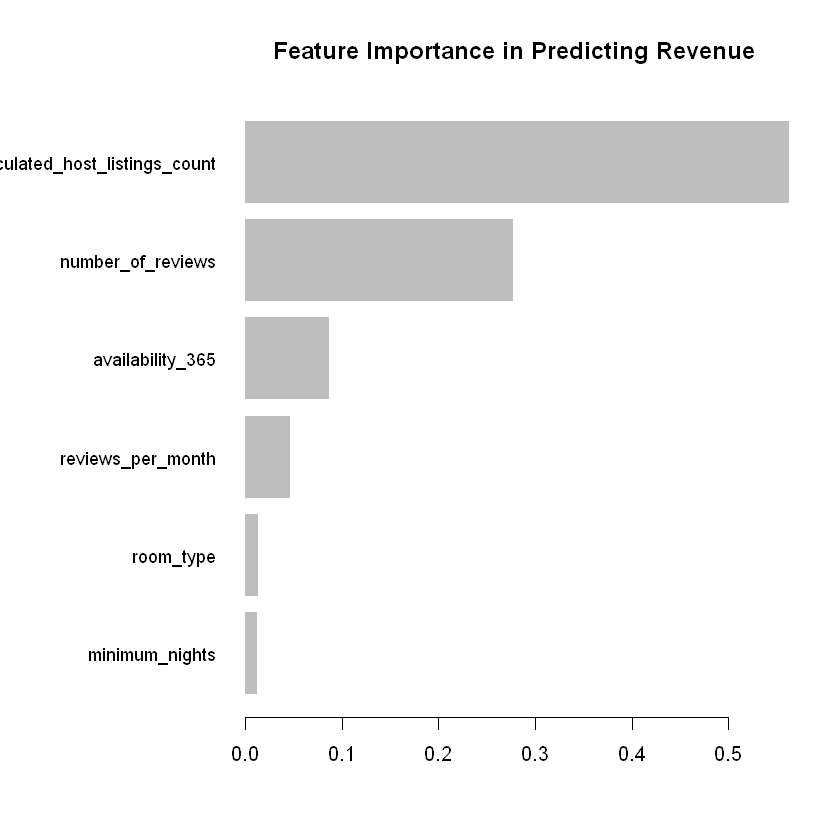

In [43]:
# Prepare data for XGBoost
xgb_data = airbnb %>%
  select(price, room_type, minimum_nights, number_of_reviews, reviews_per_month, availability_365, calculated_host_listings_count)

# Convert categorical variables to numeric encoding
xgb_data$room_type = as.numeric(as.factor(xgb_data$room_type))

# Split into training and testing
set.seed(123)
trainIndex = createDataPartition(xgb_data$price, p = 0.7, list = FALSE)
train_xgb = xgb_data[trainIndex,]
test_xgb = xgb_data[-trainIndex,]

# Convert to XGBoost format
train_matrix = as.matrix(train_xgb[,-1])
test_matrix = as.matrix(test_xgb[,-1])
train_labels = train_xgb$price
test_labels = test_xgb$price

# Train XGBoost model
params = list(eta = 0.2, max_depth = 6, min_child_weigth = 1)
xgb_model = xgboost(data = train_matrix, label = train_labels, nrounds = 20, objective = "reg:squarederror",
                   params = params, verbose = 0, verbosity = 0)

# Make predictions
pred_xgb = predict(xgb_model, test_matrix)

# Calculate RMSE
rmse_xgb = sqrt(mean((pred_xgb - test_labels)^2))
print(paste("XGBoost RMSE:", rmse_xgb))

# Feature Importance
importance = xgb.importance(feature_names = colnames(train_matrix), model = xgb_model)
xgb.plot.importance(importance, main = "Feature Importance in Predicting Revenue")

Using XGBoost helped to improve the RMSE slightly. Depending on price ranges, the RMSE of 536 could technically be small given the context of data. 


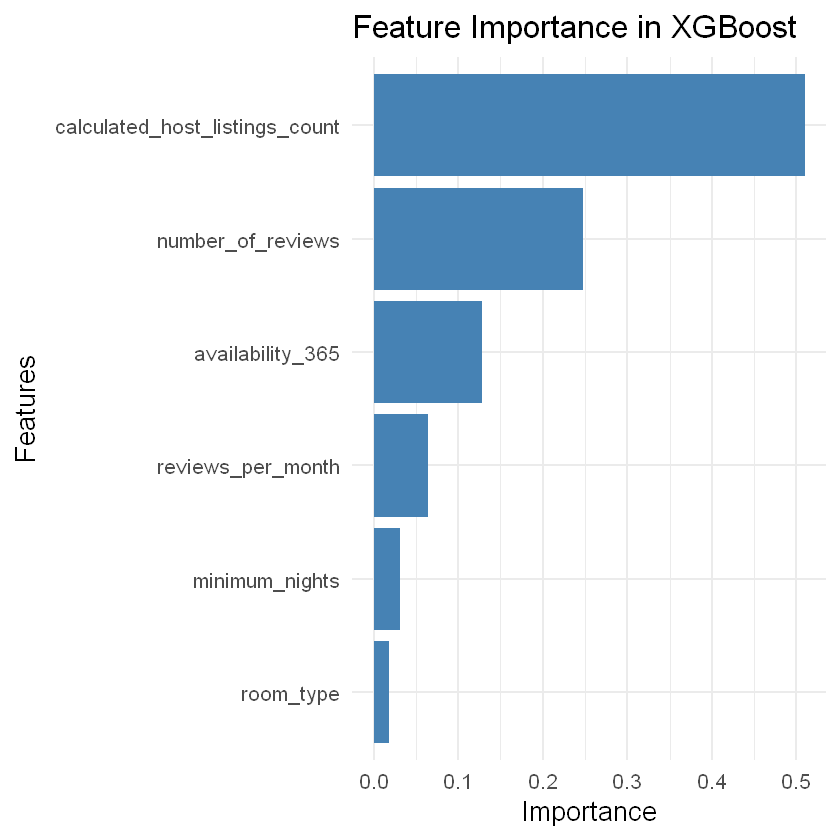

In [27]:
# Convert feature importance to a dataframe
importance_df <- xgb.importance(feature_names = colnames(train_matrix), model = xgb_model)

# Plot using ggplot2 with larger text
ggplot(importance_df, aes(x = reorder(Feature, Gain), y = Gain)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Feature Importance in XGBoost", x = "Features", y = "Importance") +
  theme_minimal(base_size = 16)  # Adjust text size


In order to make Feature Importance plot more readable for powerpoint, I used ggplot.